In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile


from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from sklearn import set_config
set_config(transform_output="pandas")

In [63]:
def read_data(zip_path,file_name):
    archive = zipfile.ZipFile(zip_path, 'r')
    file = archive.open(file_name)
    df = pd.read_csv(file)
    return df

In [64]:
df = read_data("data.zip","Base.csv")
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (1000000, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_

In [65]:
TARGET = "fraud_bool"
FEATURES = df.drop(columns="fraud_bool").columns
X = df[FEATURES]
y= df[TARGET]

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y,random_state=42)

In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 694602 to 228494
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   income                            900000 non-null  float64
 1   name_email_similarity             900000 non-null  float64
 2   prev_address_months_count         900000 non-null  int64  
 3   current_address_months_count      900000 non-null  int64  
 4   customer_age                      900000 non-null  int64  
 5   days_since_request                900000 non-null  float64
 6   intended_balcon_amount            900000 non-null  float64
 7   payment_type                      900000 non-null  object 
 8   zip_count_4w                      900000 non-null  int64  
 9   velocity_6h                       900000 non-null  float64
 10  velocity_24h                      900000 non-null  float64
 11  velocity_4w                       900000 non-null  f

In [69]:
X_train.nunique().sort_values(ascending=True)

device_fraud_count                       1
keep_alive_session                       2
source                                   2
foreign_request                          2
has_other_cards                          2
phone_mobile_valid                       2
phone_home_valid                         2
email_is_free                            2
device_distinct_emails_8w                4
device_os                                5
payment_type                             5
housing_status                           7
employment_status                        7
month                                    8
income                                   9
customer_age                             9
proposed_credit_limit                   12
bank_months_count                       33
date_of_birth_distinct_emails_4w        40
prev_address_months_count              374
current_address_months_count           422
credit_risk_score                      550
bank_branch_count_8w                  2323
zip_count_4

In [70]:
low_unique_columns = []
binary_cols = []
categorical_cols = X_train.select_dtypes("object").columns
for col in X_train.columns:
    unique_count = X_train[col].nunique()
    if unique_count < 50:
        low_unique_columns.append(col)
    
    if unique_count == 2:
        binary_cols.append(col)

In [71]:
X_train[categorical_cols].nunique()

payment_type         5
employment_status    7
housing_status       7
source               2
device_os            5
dtype: int64

In [72]:
for col in categorical_cols:
    print(X_train[col].value_counts())

payment_type
AB    333635
AA    232433
AC    226786
AD    106886
AE       260
Name: count, dtype: int64
employment_status
CA    657452
CB    124250
CF     39558
CC     34024
CD     23852
CE     20460
CG       404
Name: count, dtype: int64
housing_status
BC    334667
BB    235095
BA    152746
BE    152204
BD     23543
BF      1522
BG       223
Name: count, dtype: int64
source
INTERNET    893633
TELEAPP       6367
Name: count, dtype: int64
device_os
other        308217
linux        299721
windows      237146
macintosh     48437
x11            6479
Name: count, dtype: int64


In [73]:
fraud_data = X_train.loc[y_train[y_train == 1].index]

In [74]:
for col in categorical_cols:
    print(fraud_data[col].value_counts())

payment_type
AC    3777
AB    3752
AA    1238
AD    1158
AE       1
Name: count, dtype: int64
employment_status
CA    8000
CB     856
CC     845
CD      91
CF      81
CE      46
CG       7
Name: count, dtype: int64
housing_status
BA    5740
BC    2034
BB    1407
BE     531
BD     206
BF       7
BG       1
Name: count, dtype: int64
source
INTERNET    9825
TELEAPP      101
Name: count, dtype: int64
device_os
windows      5842
other        1795
linux        1546
macintosh     669
x11            74
Name: count, dtype: int64


We can safely change some variable names to 'other'. HOCAYA SOR

In [75]:
def reduce_categories(df,col_list,cat_list):
    data = df.copy()
    for i in range(len(col_list)):
        data[col_list[i]] = data[col_list[i]].apply(lambda x:"other" if x not in cat_list[i] else x)

    return data

In [76]:
num_cols = list(X_train.select_dtypes(include=np.number).columns)

In [77]:
num_cols = [x for x in num_cols if x not in low_unique_columns]

<Axes: >

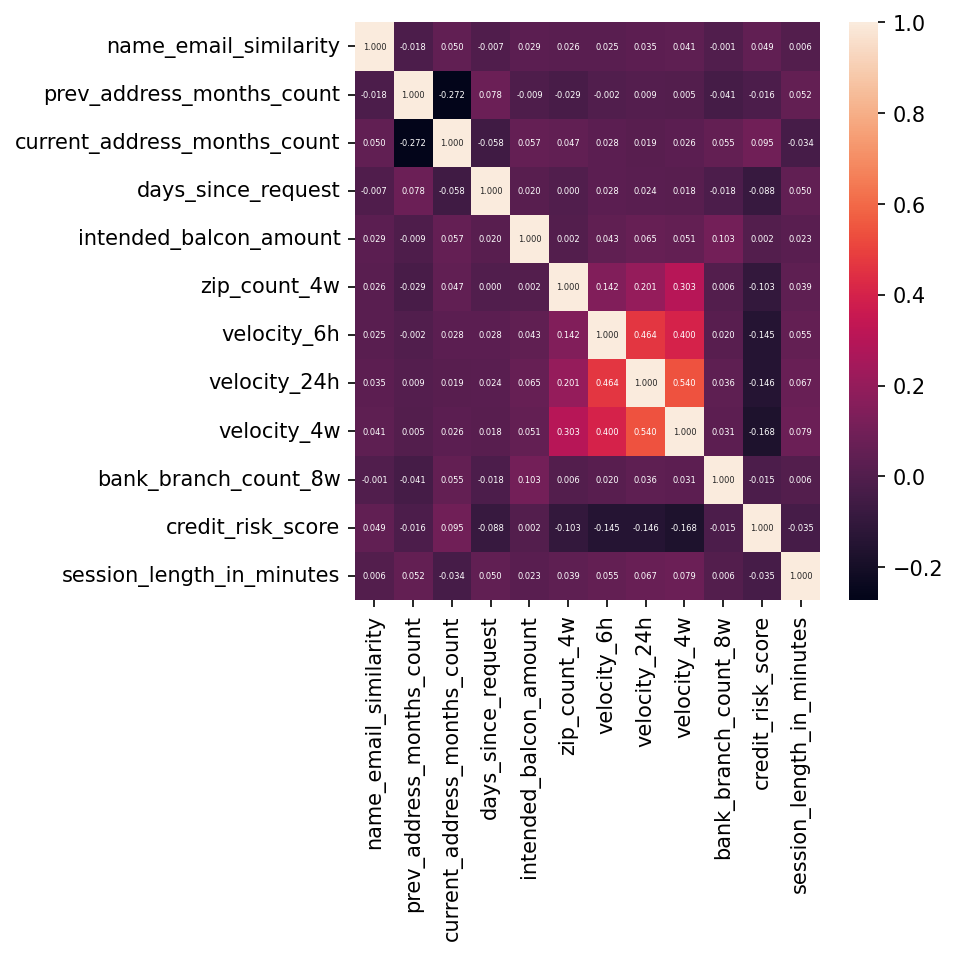

In [78]:
plt.figure(figsize=(5,5),dpi=150)
sns.heatmap(X_train[num_cols].corr(),annot=True,fmt=".3f",annot_kws={"size":4})

In [111]:
def preprocess(df):

    '''
    df: Unprocessed dataframe
    ct: Columntransformer object
    fit_transform: If true, return fit_transform. If false, return transform
    
    
    '''
    cat_col_list = ["device_os","housing_status","employment_status","payment_type"]
 

    cat_list_to_reduce = [["windows"],
                        ["BA"],
                        ["CA"],
                        ["AC","AB"]]
    df = df.drop(columns="device_fraud_count")
    transformed_df = reduce_categories(df,cat_col_list,cat_list_to_reduce)

    return transformed_df
    

    

In [ ]:
transformed_X_train = preprocess(X_train)
transformed_X_test = preprocess(X_test)

In [114]:
num_cols = transformed_X_train.select_dtypes(include=np.number).columns
cat_cols = transformed_X_train.select_dtypes("object").columns
ct = ColumnTransformer(
    transformers=[
        ("num",StandardScaler(),num_cols),
        ("cat",OneHotEncoder(sparse_output=False,drop="first"),cat_cols)
    ]
)

In [115]:
tranformed_X_train = ct.fit_transform(transformed_X_train)
transformed_X_test = ct.transform(transformed_X_test)

In [123]:
X_train["Fraud"] = y.loc[X_train.index]

In [148]:
tranformed_X_train["Fraud"] = y.loc[X_train.index]

In [154]:
num_cols = [col for col in tranformed_X_train.columns if "num__" in col]

ValueError: Could not interpret value `num__income` for `y`. An entry with this name does not appear in `data`.

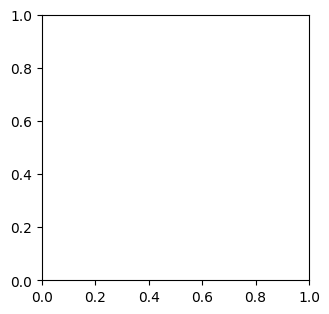

In [157]:
plt.figure(figsize=(20,20),dpi=100)
c = 1
for cat in num_cols:
    plt.subplot(5, 5, c)
    sns.boxplot(data=transformed_X_train,y=cat)
    c +=1

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
pipe = make_pipeline(ct,RandomForestClassifier())

In [97]:
train_score = pipe.score(X_train,y_train)
test_score = pipe.score(X_test,y_test)

print(f"Train accuracy: {train_score}")
print(f"Test accuracy: {test_score}")

Train accuracy: 0.99998
Test accuracy: 0.98896


In [98]:
from sklearn.metrics import confusion_matrix

In [99]:
preds = pipe.predict(X_test)

cm = confusion_matrix(y_test,preds)

<Axes: >

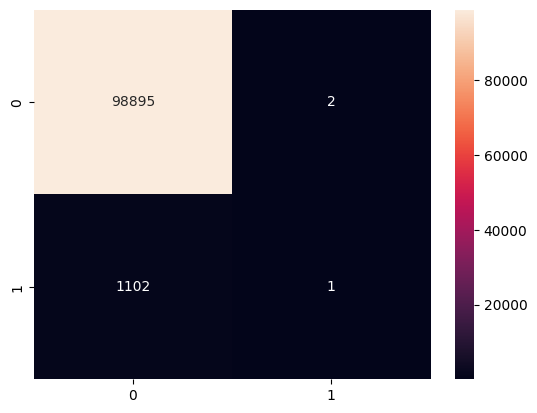

In [100]:
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
from imblearn